In [1]:
'''
classiferModel V06
Version Discription: V05 with datasetprocessor; add CrossEntropyLoss with class weights & FocalLoss
Last Update: 20241109
'''

'\nclassiferModel V06\nVersion Discription: V05 with datasetprocessor; add CrossEntropyLoss with class weights & FocalLoss\nLast Update: 20240901\n'

## Library

In [2]:
# Standard library imports
import csv
import json
import os
import pickle
import random
import re
import string
from collections import Counter, OrderedDict
from datetime import datetime
from functools import partial
from typing import Any, List, Optional, Tuple

In [3]:
# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import sem, t
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# PyTorch and torchvision imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.checkpoint as cp
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import transforms

## DatasetPreprocessor

In [5]:
class DatasetPreprocessor:
    def __init__(self, folder_0, folder_1, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
        self.folder_0 = folder_0
        self.folder_1 = folder_1
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.data = []
        self.labels = []
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    def process_file(self, filepath):
        data = np.load(filepath)
        lead, rhythm = data['arr_0'], data['arr_1']

        # Normalize
        lead = self.normalize(-450, 450, lead, newRange=(-1, 1))
        rhythm = self.normalize(-450, 450, rhythm, newRange=(-1, 1))

        # Reshape into 15 x 1250
        if rhythm.size != 0:
            split_r = np.split(rhythm, 4)
            for splits in split_r[1:]:
                lead = np.concatenate((lead, splits.reshape(1, -1)), axis=0)
            lead = np.expand_dims(lead, axis=0)
            tensor = torch.FloatTensor(lead)
            return tensor

    def normalize(self, xmin, xmax, a, newRange=(0, 1)):
        a[a > xmax] = xmax
        a[a < xmin] = xmin
        norm = (a - xmin)/(xmax - xmin)
        return norm * (newRange[1] - newRange[0]) + newRange[0]
        return norm

    def load_and_process_data(self, target_extension='.npz'):
        # Load and process files from label 0 folder
        for filename in os.listdir(self.folder_0):
            filepath = os.path.join(self.folder_0, filename)
            if os.path.isfile(filepath) and filename.endswith(target_extension):
                tensor = self.process_file(filepath)
                if tensor is not None:
                    self.data.append((filename, tensor, 0))  # Label is 0
                    self.labels.append(0)
                else:
                    print(f'{filename}\'s tensor is NaN (label == 1)')

        # Load and process files from label 1 folder
        for filename in os.listdir(self.folder_1):
            filepath = os.path.join(self.folder_1, filename)
            if os.path.isfile(filepath) and filename.endswith(target_extension):
                tensor = self.process_file(filepath)
                if tensor is not None:
                    self.data.append((filename, tensor, 1))  # Label is 1
                    self.labels.append(1)
                else:
                    print(f'{filename}\'s tensor is NaN (label == 1)')

    def stratified_split(self):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=(1 - self.train_ratio), random_state=42)
        train_indices, temp_indices = next(sss.split(self.data, self.labels))

        val_test_ratio = self.val_ratio / (self.val_ratio + self.test_ratio)
        sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=(1 - val_test_ratio), random_state=42)
        val_indices, test_indices = next(sss_val_test.split([self.labels[i] for i in temp_indices], 
                                                            [self.labels[i] for i in temp_indices]))

        train_data = [self.data[i] for i in train_indices]
        val_data = [self.data[temp_indices[i]] for i in val_indices]
        test_data = [self.data[temp_indices[i]] for i in test_indices]

        return train_data, val_data, test_data

    def save_datasets(self, train_data, val_data, test_data):
        train_path = f'{self.timestamp}_train_dataset.pkl'
        val_path = f'{self.timestamp}_val_dataset.pkl'
        test_path = f'{self.timestamp}_test_dataset.pkl'

        with open(train_path, 'wb') as f:
            pickle.dump(train_data, f)

        with open(val_path, 'wb') as f:
            pickle.dump(val_data, f)

        with open(test_path, 'wb') as f:
            pickle.dump(test_data, f)

        print(f"Datasets saved successfully at {self.timestamp}.")

    def process_and_save(self):
        self.load_and_process_data()
        # train_data, val_data, test_data = self.split_data()
        train_data, val_data, test_data = self.stratified_split()
        self.save_datasets(train_data, val_data, test_data)

## Dataset Creation

In [6]:
# # Data source
# folder_0 = 'data/waveform_like_data_without_outliers/random_576'
# folder_1 = 'data/waveform_like_data_without_outliers/ischemic'

# # Create an instance of DatasetPreprocessor
# preprocessor = DatasetPreprocessor(folder_0, folder_1)

# # Process the data and save the datasets
# preprocessor.process_and_save()

## ClassifierModel

In [7]:
'''
hyperparameters = {
    batch_size
    growth_rate
    block_config
    num_init_features
    num_classes
    lr
    num_epochs
}   
'''

'\nhyperparameters = {\n    batch_size\n    growth_rate\n    block_config\n    num_init_features\n    num_classes\n    lr\n    num_epochs\n}   \n'

In [8]:
# Define the FocalLoss class if you want to use Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [9]:
class ClassifierModel():
    def __init__(self, hyperparameters={}):
        self.hyperparameters = hyperparameters
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
#             self.device = torch.device('cpu')
            # using GPU on Apple Silicon
            self.device = torch.device('mps') 
            print('Device:', self.device)
        
    def data_loader(self, train_filename, val_filename, test_filename):
        # Load data from files
        with open(train_filename, 'rb') as train_file:
            train_data = pickle.load(train_file)

        with open(val_filename, 'rb') as val_file:
            val_data = pickle.load(val_file)

        with open(test_filename, 'rb') as test_file:
            test_data = pickle.load(test_file)
            
        train_dataset = [(tesnor_, label) for idx, tesnor_, label in train_data] 
        val_dataset = [(tesnor_, label) for idx, tesnor_, label in val_data]
        test_dataset = [(tesnor_, label) for idx, tesnor_, label in test_data]
        
        self.num_train = len(train_dataset) 
        self.num_val = len(val_dataset)
        self.num_test = len(test_dataset)
        
        print("num_train:", self.num_train)
        print("num_val:", self.num_val)
        print("num_test:", self.num_test)
        
        self.mini_trains = DataLoader(train_dataset, batch_size=self.hyperparameters.get("batch_size"), shuffle=True)
        self.mini_vals = DataLoader(val_dataset, batch_size=self.hyperparameters.get("batch_size"), shuffle=False)
        self.mini_test = DataLoader(test_dataset, batch_size=self.hyperparameters.get("batch_size"), shuffle=False)
    
    # Training 
    def train(self, which_dataset, add_test=False, save_results=False, save_model=False):
        def evaluate_predictor(model, epoch, mini_vals, device, loss):
            model.eval()
            with torch.no_grad():
                acc_count = 0
                for x, y in mini_vals:
                    x=x.to(device)
                    y=y.to(device)
                    scores=model(x)
                    loss = loss_function(scores, y)
                    predictions=scores.max(1)[1]
                    acc = predictions.eq(y).sum().item()
                    acc_count += acc
                print(f'Epoch[{epoch+1}] Validation Acc: {acc_count/self.num_val} Loss: {loss}')
                return acc_count/self.num_val, loss
        
        def get_training_accuracy(model, epoch, mini_trains, device, loss):
            model.eval()
            with torch.no_grad():
                acc_count = 0
                for x, y in mini_trains:
                    x=x.to(device)
                    y=y.to(device)
                    scores=model(x)
                    predictions=scores.max(1)[1]
                    acc = predictions.eq(y).sum().item()
                    acc_count += acc
                print(f'Epoch[{epoch+1}] Training Acc: {acc_count/self.num_train} Loss: {loss}')
                return acc_count/self.num_train
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        
        model = DenseNet(
            self.hyperparameters.get("growth_rate"),
            self.hyperparameters.get("block_config"),
            self.hyperparameters.get("num_init_features")
        )
        num_flatten = model.classifier.in_features
        # model.classifier = nn.Linear(num_flatten, self.hyperparameters.get("num_classes"))
        # Add Dropout
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Add 50% Dropout
            nn.Linear(num_flatten, self.hyperparameters.get("num_classes"))
        )

        if torch.cuda.is_available():
            model.cuda()
        else:
            # move model to GPU
            model.to('mps')

        # Calculate class weights if using CrossEntropyLoss with weights
        # class_weights = torch.tensor([107/466, 359/466], dtype=torch.float32)  # Adjust according to our data distribution
        
        # Choose the loss function
        # Use CrossEntropyLoss with class weights
        # loss_function = nn.CrossEntropyLoss(weight=class_weights.to(self.device))
        
        # Alternatively, use FocalLoss 
        # loss_function = FocalLoss(alpha=1, gamma=2)

        # Alternatively, use simple CrossEntropyLoss
        loss_function = nn.CrossEntropyLoss()
        # optimizer = optim.Adam(model.parameters(), lr=self.hyperparameters.get("lr"))
        # Add weight decay
        optimizer = optim.Adam(model.parameters(), lr=self.hyperparameters.get("lr"), weight_decay=1e-4)
        
        accuracy_history = [[], []]
        loss_history =[[], []]
        num_batches_per_epoch = len(self.mini_trains.dataset) // self.hyperparameters.get("batch_size")
        total_iterations = num_batches_per_epoch * self.hyperparameters.get("num_epoch")
        epoch_iterations = []
        
        for epoch in range(self.hyperparameters.get("num_epoch")):
            num_iters = 0
            for x, y in self.mini_trains:
                model.train()
                x = x.to(self.device)
                y = y.to(self.device)
                scores = model(x)
                loss = loss_function(scores, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if num_iters % 10 == 0:
                    accuracy_history[0].append(get_training_accuracy(model, epoch, self.mini_trains, self.device, loss))
                    acc, v_loss = evaluate_predictor(model, epoch, self.mini_vals, self.device, loss)
                    accuracy_history[1].append(acc)
                    loss_history[0].append(loss.cpu().detach().numpy())
                    loss_history[1].append(v_loss.cpu().detach().numpy())
                    epoch_iterations.append(epoch + num_iters / num_batches_per_epoch)
                    print("")
                num_iters += 1
        
        # Calculate the range for the x-axis
        iterations = range(0, len(accuracy_history[0]))
        
        # plot and save graphs
        plt1 = plt.figure() 
        plt.plot(epoch_iterations, accuracy_history[0])
        plt.plot(epoch_iterations, accuracy_history[1])
        plt.legend(['Train Acc', 'Val Acc'])
        plt.show()
        plt2 = plt.figure()
        plt.plot(epoch_iterations, loss_history[0])
        plt.plot(epoch_iterations, loss_history[1])
        plt.legend(['Train Loss', 'Val Loss'])
        plt.show()
        
        torch.save(model, "test_model.pth")
        
        if add_test:
            test_acc = self.test(save_results, timestamp)
        
        if save_results:
            plt1.savefig(f'results/{timestamp}_acc_plot.png')
            plt2.savefig(f'results/{timestamp}_loss_plot.png')
            
            # Extract the last epoch's training and validation accuracy
            last_epoch_train_acc = accuracy_history[0][-1]  
            last_epoch_val_acc = accuracy_history[1][-1]
            # Prepare data to be added to the results table
            results_data = {
                "Dataset Label": f'Dataset created on {which_dataset}',
                "Date": timestamp,
                "Last Epoch Train Acc": last_epoch_train_acc,
                "Last Epoch Val Acc": last_epoch_val_acc,
                "Test Acc": test_acc,
            }
            
            # Convert 'block_config' tuple to a string so it could be saved in the result table
            hyperparams = self.hyperparameters
            if "block_config" in hyperparams:
                hyperparams["block_config"] = [str(hyperparams["block_config"])]
            
            results_data.update(hyperparams)
            results_df = pd.DataFrame(results_data)
            
            # Save to a physical file
            results_folder = 'results'
            if not os.path.exists(results_folder):
                os.makedirs(results_folder)
            results_file = os.path.join(results_folder, 'results_history.csv')
            
            # Create & update results
            if os.path.isfile(results_file):
                results_df.to_csv(results_file, mode='a', header=False, index=False)
            else:
                results_df.to_csv(results_file, index=False)
        
        if save_model:
            model.to('cpu')
            output_dir = f'results/models'
            os.makedirs(output_dir, exist_ok=True)
            torch.save(model, f'{output_dir}/{timestamp}_model.pth')
    
    def test(self, save_results, timestamp="NA"):
        model = torch.load("test_model.pth")
        model.eval()
        true_labels_lst = []
        predicted_labels_lst = []
        predicted_probabilities_lst = []  # To store predicted probabilities

        with torch.no_grad():
            acc_count = 0
            for x, y in self.mini_test:
                x = x.to(self.device)
                y = y.to(self.device)
                scores = model(x)
                predictions = scores.max(1)[1]
                
                true_labels_lst.append(y)
                predicted_labels_lst.append(predictions)
                
                predicted_probabilities_lst.append(scores[:, 1])  # Assuming binary classification
                
                acc = predictions.eq(y).sum().item()
                acc_count += acc
            accuracy = acc_count / self.num_test
            print(f'Testing Acc: {accuracy}')
        
        # Confusion matrix
        true_labels_tensor = torch.cat(true_labels_lst)
        predicted_labels_tensor = torch.cat(predicted_labels_lst)
        predicted_probabilities_tensor = torch.cat(predicted_probabilities_lst)  # Concatenate predicted probabilities
        
        true_labels_tensor = true_labels_tensor.cpu()
        predicted_labels_tensor = predicted_labels_tensor.cpu()
        predicted_probabilities_tensor = predicted_probabilities_tensor.cpu()
        
        true_labels = true_labels_tensor.numpy()
        predicted_labels = predicted_labels_tensor.numpy()
        
        predicted_probabilities = predicted_probabilities_tensor.numpy()
        labels = sorted(list(set(true_labels) | set(predicted_labels)))
        cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Test Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        if save_results:
            os.makedirs('results', exist_ok=True)
            plt.savefig(f'results/{timestamp}_test_cm.png')
        plt.show()
        
        # ROC curve and AUROC
        fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
        roc_auc = auc(fpr, tpr)

        # Calculate 95% confidence interval for AUC
        n_bootstraps = 2000
        bootstrapped_scores = []

        np.random.seed(42)
        for i in range(n_bootstraps):
            indices = np.random.randint(0, len(predicted_probabilities), len(predicted_probabilities))
            if len(np.unique(true_labels[indices])) < 2:
                continue
            fpr_bootstrap, tpr_bootstrap, _ = roc_curve(true_labels[indices], predicted_probabilities[indices])
            score = auc(fpr_bootstrap, tpr_bootstrap)
            bootstrapped_scores.append(score)
        
        sorted_scores = np.array(bootstrapped_scores)
        sorted_scores.sort()
        
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.fill_between(fpr, tpr, color='darkorange', alpha=0.2, label=f'95% CI [{confidence_lower:0.2f} - {confidence_upper:0.2f}]')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        if save_results:
            plt.savefig(f'results/{timestamp}_roc_curve.png')
        plt.show()
        
        # Save results to a file
        if save_results:
            results = {
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'confidence_interval': [confidence_lower, confidence_upper],
                'true_labels': true_labels.tolist(),
                'predicted_labels': predicted_labels.tolist(),
                'predicted_probabilities': predicted_probabilities.tolist()
            }
            
            with open(f'results/{timestamp}_results.json', 'w') as f:
                json.dump(results, f)
                
        return accuracy
        
    def load(self, PATH):
        model = DenseNet(
            self.hyperparameters.get("growth_rate"),
            self.hyperparameters.get("block_config"),
            self.hyperparameters.get("num_init_features")
        )
        model = torch.load(PATH)

        self.pred_model = model

    def predict(self, filepath):
        data = np.load(filepath)
        lead, rhythm = data['arr_0'], data['arr_1']
        lead = self.normalize(-450, 450, lead, newRange=(-1, 1))
        rhythm = self.normalize(-450, 450, rhythm, newRange=(-1, 1))
        split_r = np.split(rhythm, 4)
        for splits in split_r[1:]:
            lead = np.concatenate((lead, splits.reshape(1, -1)), axis=0)
        lead = np.expand_dims(lead, axis=0)
        X = torch.FloatTensor(lead)
        
        model = self.pred_model
        model.eval()

        predictions = []

        with torch.no_grad():
            X = X.unsqueeze(0)
            print(X.shape)
            X = X.to(self.device)
            outputs = model(X)
            predictions.append(outputs)
        predictions = np.concatenate([p.cpu().numpy() for p in predictions], axis=0)
        probs = np.exp(predictions)
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        preds = np.argmax(probs, axis=1)
        print(preds)

        return preds

In [10]:
class _DenseLayer(nn.Module):
    def __init__(
        self, num_input_features: int, growth_rate: int, bn_size: int, drop_rate: float, memory_efficient: bool = False
    ) -> None:
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:  # noqa: F811
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features

In [11]:
class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False,
    ) -> None:
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

In [12]:
class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

In [13]:
class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False,
    ) -> None:

        super().__init__()

        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        # add padding to ensure tensor fit minimum size for denseNets
        x = nn.functional.pad(input=x, pad=(0, 0, 10, 10), mode='constant', value=0)
        x = x.float()
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

## Train, Validation, and Test

In [14]:
model = ClassifierModel(hyperparameters={
    "batch_size": 16,
    "growth_rate": 8,
    "block_config": (3, 6, 9, 6),
    "num_init_features": 8,
    "num_classes": 2,
    "lr": 0.001,
    "num_epoch": 50,
})

Device: mps


In [15]:
# Update these variables everytime you use a new dataset
dataset_datetime = '20241015_2301'
train_set = f'{dataset_datetime}_train_dataset.pkl'
val_set = f'{dataset_datetime}_val_dataset.pkl'
test_set = f'{dataset_datetime}_test_dataset.pkl'
model.data_loader(train_set, val_set, test_set)

num_train: 921
num_val: 115
num_test: 116


Epoch[1] Training Acc: 0.5874049945711184 Loss: 0.6361058950424194
Epoch[1] Validation Acc: 0.591304347826087 Loss: 0.6932241320610046

Epoch[1] Training Acc: 0.499457111834962 Loss: 0.6507890224456787
Epoch[1] Validation Acc: 0.5043478260869565 Loss: 0.8467715382575989

Epoch[1] Training Acc: 0.499457111834962 Loss: 0.5792036056518555
Epoch[1] Validation Acc: 0.5043478260869565 Loss: 1.1560518741607666

Epoch[1] Training Acc: 0.499457111834962 Loss: 0.5464553833007812
Epoch[1] Validation Acc: 0.5043478260869565 Loss: 1.43018639087677

Epoch[1] Training Acc: 0.500542888165038 Loss: 0.4584255814552307
Epoch[1] Validation Acc: 0.5043478260869565 Loss: 1.3283520936965942

Epoch[1] Training Acc: 0.49728555917481 Loss: 0.6111948490142822
Epoch[1] Validation Acc: 0.4956521739130435 Loss: 0.6553285717964172

Epoch[2] Training Acc: 0.6948968512486428 Loss: 0.4664198160171509
Epoch[2] Validation Acc: 0.6260869565217392 Loss: 0.6518108248710632

Epoch[2] Training Acc: 0.6199782844733985 Loss: 0.

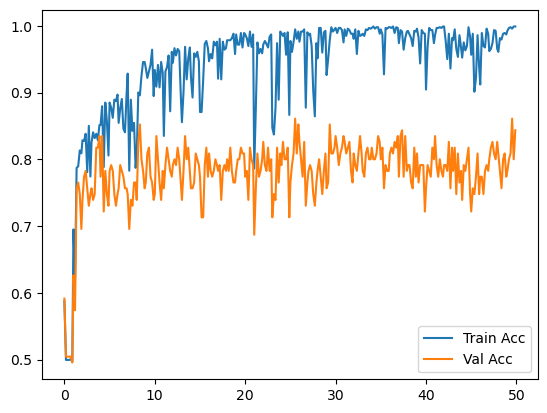

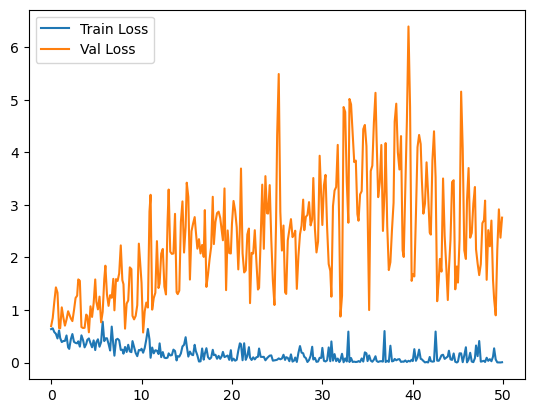

Testing Acc: 0.8793103448275862


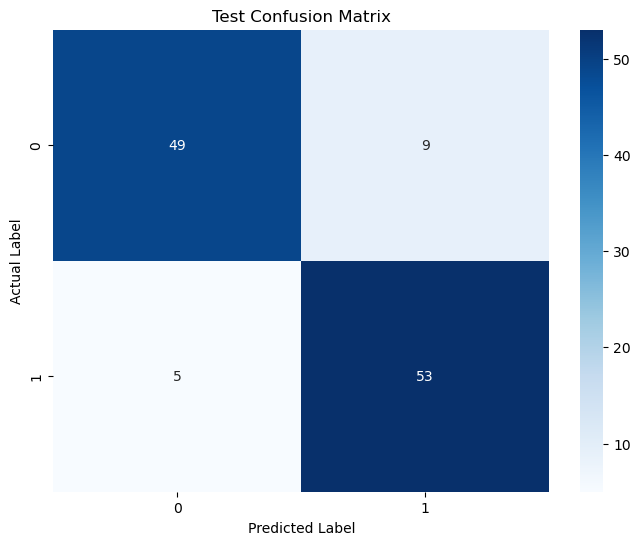

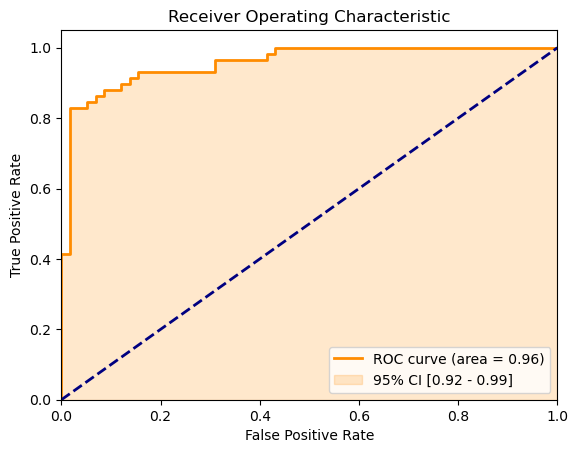

In [16]:
# Double check the dataset filenames and datetime before you start training the model
model.train(dataset_datetime, add_test=True, save_results=True, save_model=True)

In [17]:
# Read previously saved results
results_df = pd.read_csv('results/results_history.csv')
df_reversed = results_df.iloc[::-1].reset_index(drop=True)
df_reversed

,Dataset Label,Date,Last Epoch Train Acc,Last Epoch Val Acc,Test Acc,batch_size,growth_rate,block_config,num_init_features,num_classes,lr,num_epoch
0,Dataset created on 20241015_2301,20241109_1430,0.998914,0.843478,0.879310,16,8,"(3, 6, 9, 6)",8,2,0.001,50
1,Dataset created on 20241015_2301,20241017_0909,0.956569,0.765217,0.862069,8,4,"(2, 4, 6, 4)",6,2,0.001,50
2,Dataset created on 20241015_2301,20241016_1639,0.992400,0.826087,0.887931,8,4,"(2, 4, 6, 4)",6,2,0.001,50
3,Dataset created on 20241015_2301,20241016_0631,0.998914,0.800000,0.862069,8,6,"(3, 6, 9, 6)",8,2,0.001,100
4,Dataset created on 20241015_2301,20241015_2345,0.998914,0.860870,0.827586,8,6,"(3, 6, 9, 6)",8,2,0.001,100
5,Dataset created on 20241015_2301,20241015_2324,0.997828,0.808696,0.896552,32,8,"(3, 6, 9, 6)",16,2,0.001,100
6,Dataset created on 20241015_2301,20241015_2302,0.998914,0.817391,0.870690,32,12,"(3, 6, 12, 8)",32,2,0.001,100
7,Dataset created on 20240914_2015,20241015_1705,0.998914,0.800000,0.862069,16,12,"(3, 6, 12, 8)",16,2,0.001,100
8,Dataset created on 20240914_2015,20241013_2229,0.998914,0.800000,0.870690,32,12,"(3, 6, 12, 8)",16,2,0.001,100
9,Dataset created on 20240914_2015,20240914_2254,0.998914,0.800000,0.887931,32,12,"(3, 6, 12, 8)",16,2,0.001,100
